# fMRI4a -- Compute the baseline decodability of Motor responses (LINDEX v. LMID and RINDEX v. RMID)
## Using ActFlow, All to one, via RidgeFC
# Within subjects

## Takuya Ito
#### 01/21/2019

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
import nibabel as nib
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.api as sm
import sklearn.svm as svm
import statsmodels.sandbox.stats.multicomp as mc
import sklearn
from sklearn.feature_selection import f_classif
import seaborn as sns
import h5py
os.sys.path.append('glmScripts/')
import taskGLMPipeline as tgp
import statsmodels.api as sm
import sys
sys.path.append('utils/')
import loadExperimentalData as led

sns.set_style("whitegrid")
plt.rcParams["font.family"] = "FreeSans"


In [4]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']

basedir = '/projects3/SRActFlow/'

# Using final partition
networkdef = np.loadtxt('/projects3/NetworkDiversity/data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = '/projects/AnalysisTools/ParcelsGlasser2016/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(xticks.keys())
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

# 0.0 Define functions for loading data

In [5]:
def loadMotorResponses(subj):
#     x = tgp.loadTaskTiming(subj,'betaSeries')
#     stimIndex = np.asarray(x['stimIndex'])
#     ind = np.where(stimIndex=='motorResponse')[0]
    
    datadir = basedir + 'data/postProcessing/hcpPostProcCiric/'
    h5f = h5py.File(datadir + subj + '_glmOutput_data.h5','r')
    data = h5f['taskRegression/betaSeries_24pXaCompCorXVolterra_taskReg_betas_canonical'][:].copy()
    # Probe activations are starting from index 128 (first 128 are encoding activations)
    data = data[:,128:].copy()
#     data = np.loadtxt(datadir + subj + '_motorResponse_taskBetas_Surface64k_GSR.csv',delimiter=',')
#     data = data[:,-4:]
    h5f.close()
    return data
        

In [6]:
def loadRSFCMapping(subj,source,target):
    fcdir = '/projects3/SRActFlow/data/results/pcaFC/pairwiseFC/'
#     filename = fcdir + 'TargetParcel' + str(roi) + '_RidgeFC.h5'
    filename = fcdir + 'SourceParcel' + str(source) + 'TargetParcel' + str(target) + '_pcaPairwiseFC_nozscore.h5'
    h5f = h5py.File(filename,'r')
    fcmapping = h5f[subj]['sourceToTargetMapping'][:].copy()
    h5f.close()
    return fcmapping


## Load masks
def loadMask(roi,dilated=True):
    maskdir = basedir + 'data/results/surfaceMasks/'
    if dilated:
        maskfile = maskdir + 'GlasserParcel' + str(roi) + '_dilated_10mm.dscalar.nii'
    else:
        maskfile = maskdir + 'GlasserParcel' + str(roi) + '.dscalar.nii'
    maskdata = np.squeeze(nib.load(maskfile).get_data())
    
    return maskdata
        

## 0.1 Load data

In [7]:
# gsr = True
nTrials = 384
data_task = np.zeros((len(glasser2),nTrials,len(subjNums)))

scount = 0
for subj in subjNums:
    if scount%4==0: print 'Loading subject', scount, '/', len(subjNums)
    data_task[:,:,scount] = loadMotorResponses(subj)
    scount += 1

Loading subject 0 / 96
Loading subject 4 / 96
Loading subject 8 / 96
Loading subject 12 / 96
Loading subject 16 / 96
Loading subject 20 / 96
Loading subject 24 / 96
Loading subject 28 / 96
Loading subject 32 / 96
Loading subject 36 / 96
Loading subject 40 / 96
Loading subject 44 / 96
Loading subject 48 / 96
Loading subject 52 / 96
Loading subject 56 / 96
Loading subject 60 / 96
Loading subject 64 / 96
Loading subject 68 / 96
Loading subject 72 / 96
Loading subject 76 / 96
Loading subject 80 / 96
Loading subject 84 / 96
Loading subject 88 / 96
Loading subject 92 / 96


# 1.0 Define functions for motor response decodings

In [8]:
## from scipy.spatial.distance import cdist

def motorResponseDecodings((data, actflow, subj, hand, ncvs)):
    """
    Run a within-subject classification
    Assumes data is a space X feature matrix
    Decode responses on each hand separately from CPRO data
    """
    
    df_task = led.loadExperimentalData(subj) 
    # Motor responses are 'b (LMID), y (LIND), g (RIND), r (RMID)'
    motor_responses = df_task['MotorResponses'].values
    if hand=='left':
        fing1_ind = np.where(motor_responses=='b')[0] #lmid
        fing2_ind = np.where(motor_responses=='y')[0] #lind
    elif hand=='right':
        fing1_ind = np.where(motor_responses=='g')[0] #rind
        fing2_ind = np.where(motor_responses=='r')[0] #rmid
    
    fing1_nsamples = len(fing1_ind)
    fing2_nsamples = len(fing2_ind)
    
    labels = []
    labels.extend(np.repeat(0,fing1_nsamples))
    labels.extend(np.repeat(1,fing2_nsamples))
    
    # Find the minimum number of unique samples
    min_unique_samples = np.min([fing1_nsamples,fing2_nsamples])
    
    svm_mat1 = data[:,fing1_ind].T
    svm_mat2 = data[:,fing2_ind].T
    svm_mat = np.vstack((svm_mat1,svm_mat2))
    
    actflow_mat1 = actflow[:,fing1_ind].T
    actflow_mat2 = actflow[:,fing2_ind].T
    actflow_mat = np.vstack((actflow_mat1, actflow_mat2))

    # Spatially demean matrix across features
    samplemean = np.mean(svm_mat,axis=1)
    samplemean.shape = (len(samplemean),1)
    svm_mat = svm_mat - samplemean
    
    actflowmean = np.mean(actflow_mat,axis=1)
    actflowmean.shape = (len(actflow_mat),1)
    actflow_mat = actflow_mat - actflowmean

    scores = randomSplitLOOBaselineCV(ncvs, svm_mat, actflow_mat, labels)

    return scores

def randomSplitLOOBaselineCV(ncvs, svm_mat, actflow_mat, labels):
    """
    Runs cross validation for a within-subject SVM analysis
    Using boot-strapped CV
    Approx. 80% train set, 20% test set
    """
    
    # Data set might be unbalanced, so find minimium number of unique samples
    maxpossible = len(labels)
    for i in np.unique(labels):
        if np.sum(labels==i)<maxpossible:
            maxpossible = np.sum(labels==i)
    min_unique_samples = maxpossible
    # Train set is approximately 80%
    n_trainset_per_cond = np.floor(min_unique_samples*.8)
    # Test set is the remaining samples
    n_testset_per_cond = min_unique_samples - n_trainset_per_cond
    
    accuracies = []
    for cv in range(ncvs):
        # Define training and test set labels
        train_ind = []
        trainlabels = []
        for i in np.unique(labels):
            ind = np.where(labels==i)[0]
            train_ind.extend(np.random.choice(ind,int(n_trainset_per_cond),replace=False))
            trainlabels.extend(np.repeat(i,n_trainset_per_cond))
        train_ind = np.asarray(train_ind)
        test_ind = np.delete(np.arange(len(labels)),train_ind)
        testlabels = np.delete(labels,train_ind)
        
        # Define train set and test set matrices
        trainset = svm_mat[train_ind,:]
        testset = actflow_mat[test_ind,:]
        
        # Normalize trainset and testset using trainset stats
        mean = np.mean(svm_mat[train_ind,:],axis=0)
        mean.shape = (1,len(mean))
        std = np.std(svm_mat[train_ind,:],axis=0)
        std.shape = (1,len(std))

        trainset = np.divide((trainset - mean),std)
        
        # normalize test set using training labels from actflow data set
        mean = np.mean(actflow_mat[train_ind,:],axis=0)
        mean.shape = (1,len(mean))
        std = np.std(actflow_mat[train_ind,:],axis=0)
        std.shape = (1,len(std))
        
        testset = np.divide((testset - mean),std)

#         ## Feature selection and downsampling
#         unique_labels = np.unique(labels)
#         feat1_labs = np.where(trainlabels==unique_labels[0])[0]
#         feat2_labs = np.where(trainlabels==unique_labels[1])[0]
#         # Perform t-test
#         t, p = stats.ttest_rel(trainset[feat1_labs,:],trainset[feat2_labs,:],axis=0)
#         h0, qs = mc.fdrcorrection0(p)
# #         h0 = p<0.1
# #         # Construct feature masks
# #         feat1_mask = np.multiply(t>0,h0).astype(bool)
# #         feat2_mask = np.multiply(t<0,h0).astype(bool)
#         feat1_mask = t>0
#         feat2_mask = t<0
#         # Downsample training set into original vertices into 2 ROI signals
#         trainset_downsampled = np.zeros((trainset.shape[0],2))
#         trainset_downsampled[:,0] = np.nanmean(trainset[:,feat1_mask],axis=1)
#         trainset_downsampled[:,1] = np.nanmean(trainset[:,feat2_mask],axis=1)
#         trainset_downsampled = trainset[:,h0]
#         # Downsample test set into original vertices
#         testset_downsampled = np.zeros((testset.shape[0],2))
#         testset_downsampled[:,0] = np.nanmean(testset[:,feat1_mask],axis=1)
#         testset_downsampled[:,1] = np.nanmean(testset[:,feat2_mask],axis=1)
#         testset_downsampled = testset[:,h0]

#         if np.sum(feat1_mask)==0 or np.sum(feat2_mask==0):
#             accuracies.append(_decoding((trainset,testset,trainlabels,testlabels)))
#         else:
#             accuracies.append(_decoding((trainset_downsampled,testset_downsampled,trainlabels,testlabels)))
        
        accuracies.append(_decoding((trainset,testset,trainlabels,testlabels)))
        
    return np.mean(accuracies)

def _decoding((trainset,testset,trainlabels,testlabels)):

# #     clf = sklearn.linear_model.LogisticRegression()
#     clf = svm.SVC(C=1.0, kernel='linear')

#     clf.fit(trainset,trainlabels)
#     predictions = clf.predict(testset)
#     acc = predictions==testlabels
#     acc = np.mean(acc)

    unique_cond = np.unique(trainlabels)
    rdm = np.zeros((len(unique_cond),len(unique_cond)))
    acc = []
    for cond1 in unique_cond:
        mismatches = []
        prototype_ind = np.where(trainlabels==cond1)[0]
#         prototype_ind = np.random.choice(prototype_ind,size=200,replace=True)
        prototype = np.mean(trainset[prototype_ind,:],axis=0)
        for cond2 in unique_cond:
            test_ind = np.where(testlabels==cond2)[0]
#             test_ind = np.random.choice(test_ind,size=100,replace=True)
            test = np.mean(testset[test_ind,:],axis=0)
            if cond1 == cond2: 
                correct = stats.pearsonr(prototype,test)[0]
#                 correct = stats.spearmanr(prototype,test)[0]
            else:
                mismatches.append(stats.pearsonr(prototype,test)[0])
#                 mismatches.append(stats.spearmanr(prototype,test)[0])
        
        if correct > np.max(mismatches): 
            acc.append(1.0)
        else:
            acc.append(0.0)
    
    return acc

## 1.02 Generate trial-to-trial actflow predictions for both R/L S1s

## 1.1 Run actflow and decoding analyses

In [9]:
# roi_rh = 9 #left S1
# roi_lh = 189
# # roi_rh = 8 #left S1
# # roi_lh = 188
# target_rh_ind = np.where(glasser2==roi_rh)[0]
# fcmapping_rh = np.zeros((len(glasser2),len(target_rh_ind)))
# target_lh_ind = np.where(glasser2==roi_lh)[0]
# fcmapping_lh = np.zeros((len(glasser2),len(target_lh_ind)))

# scount = 0
# for subj in subjNums:
#     fcmapping_rh[:,:] = fcmapping_rh[:,:] + loadRSFCMapping(subj,roi_rh)
#     fcmapping_lh[:,:] = fcmapping_lh[:,:] + loadRSFCMapping(subj,roi_lh)
#     scount += 1

# fcmapping_rh = np.divide(fcmapping_rh,len(subjNums))
# fcmapping_lh = np.divide(fcmapping_lh,len(subjNums))

In [28]:
nproc = 20
ncvs = 10

# roi_rh = 9
# roi_lh = 189
roi_rh = 8
roi_lh = 188

roi_rh_ind = np.where(glasser2==roi_rh)[0]
roi_lh_ind = np.where(glasser2==roi_lh)[0]

# actflow_data_rh = np.zeros((len(roi_rh_ind),data_task.shape[1],nParcels,len(subjNums))) # n vertices for target region, n miniblocks, n source regions, n subjects
# actflow_data_lh = np.zeros((len(roi_lh_ind),data_task.shape[1],nParcels,len(subjNums)))

dilateLH = loadMask(roi_lh,dilated=True)
dilateRH = loadMask(roi_rh,dilated=True)
combinedDilated = dilateLH + dilateRH
# Exclude all SMN regions
smn_rois = np.where(networkdef==networkmappings['smn'])[0]

accuracies_rh = np.zeros((nParcels,len(subjNums)))
accuracies_lh = np.zeros((nParcels,len(subjNums)))

scount = 0
for subj in subjNums:
    print 'Run analysis for subject', subj, '(', scount + 1, '/', len(subjNums), ')'
    
    inputs_lh = []
    inputs_rh = []
    print '\tBegin running actflow process...'
    for roi in np.arange(nParcels):
        if roi in smn_rois: continue
        roi_ind = glasser2==(roi+1)
#         roi_ind = roi_ind - combinedDilated
        source_ind = np.where(roi_ind==1)[0]
        
        fcmapping_rh = loadRSFCMapping(subj,roi+1,roi_rh)
        fcmapping_lh = loadRSFCMapping(subj,roi+1,roi_lh)
        
        ## ACTFLOW
        # right hand responses
        actflow_data_rh = np.dot(stats.zscore(data_task[source_ind,:,scount],axis=0).T,fcmapping_rh[:,:]).T
#         actflow_data_rh = np.dot(data_task[source_ind,:,scount].T,fcmapping_rh[:,:]).T
        # left hand responses
        actflow_data_lh = np.dot(stats.zscore(data_task[source_ind,:,scount],axis=0).T,fcmapping_lh[:,:]).T
#         actflow_data_lh = np.dot(data_task[source_ind,:,scount].T,fcmapping_lh[:,:]).T

        # Gather real target data
#         data_rh = stats.zscore(data_task[roi_rh_ind,:,scount],axis=0)
#         data_lh = stats.zscore(data_task[roi_lh_ind,:,scount],axis=0)
        data_rh = data_task[roi_rh_ind,:,scount]
        data_lh = data_task[roi_lh_ind,:,scount]
        
        # Create input array for multiprocessing
        inputs_rh.append((data_rh,actflow_data_rh,subj,'right',ncvs))
        inputs_lh.append((data_lh,actflow_data_lh,subj,'left',ncvs))

    print '\tRight-hand motor response decodings'
    pool = mp.Pool(processes=nproc)
    results = pool.map_async(motorResponseDecodings,inputs_rh).get()
    pool.close()
    pool.join()
    
    i = 0
    for roi in range(nParcels):
        if roi in smn_rois: continue
        accuracies_rh[roi,scount] = results[i]
        i += 1
    
    print '\tLeft-hand motor response decodings'
    pool = mp.Pool(processes=nproc)
    results = pool.map_async(motorResponseDecodings,inputs_lh).get()
    pool.close()
    pool.join()
    
    i = 0
    for roi in range(nParcels):
        if roi in smn_rois: continue
        accuracies_lh[roi,scount] = results[i]
        i += 1
    
    scount += 1
    

Run analysis for subject 013 ( 1 / 96 )
	Begin running actflow process...
	Right-hand motor response decodings
	Left-hand motor response decodings
Run analysis for subject 014 ( 2 / 96 )
	Begin running actflow process...
	Right-hand motor response decodings
	Left-hand motor response decodings
Run analysis for subject 016 ( 3 / 96 )
	Begin running actflow process...
	Right-hand motor response decodings
	Left-hand motor response decodings
Run analysis for subject 017 ( 4 / 96 )
	Begin running actflow process...
	Right-hand motor response decodings
	Left-hand motor response decodings
Run analysis for subject 018 ( 5 / 96 )
	Begin running actflow process...
	Right-hand motor response decodings
	Left-hand motor response decodings
Run analysis for subject 021 ( 6 / 96 )
	Begin running actflow process...
	Right-hand motor response decodings
	Left-hand motor response decodings
Run analysis for subject 023 ( 7 / 96 )
	Begin running actflow process...
	Right-hand motor response decodings
	Left-h

## 1.2 Compute right-hand response statistics

In [29]:
rois = np.delete(np.arange(nParcels),smn_rois)
rois = []
rois.extend(np.where(networkdef==networkmappings['fpn'])[0])
rois.extend(np.where(networkdef==networkmappings['dan'])[0])
rois.extend(np.where(networkdef==networkmappings['con'])[0])
# rois.extend(np.where(networkdef==networkmappings['dmn'])[0])
statistics_rh = np.zeros((nParcels,3)) # acc, t, qs
ps = []
for i in rois:
    t, p = stats.ttest_1samp(accuracies_rh[i,:],0.5)
    if t>0:
        p = p/2.0
    else:
        p = 1.0-p/2.0
    ps.append(p)
    
    statistics_rh[i,0] = np.mean(accuracies_rh[i,:])
    statistics_rh[i,1] = t

statistics_rh[:,2] = 1.0
qs = mc.fdrcorrection0(ps)[1]
i = 0
for roi in rois:
    statistics_rh[roi,2] = qs[i]
    i += 1
    
sig_rois = np.where(statistics_rh[:,2]<0.1)[0]
for roi in sig_rois:
    print 'ROI', roi + 1
    print '\tAccuracy:', statistics_rh[roi,0]
    print '\tP-value:', statistics_rh[roi,2]



Text(0.5,1,'Distribution of FDR-corrected p-values')

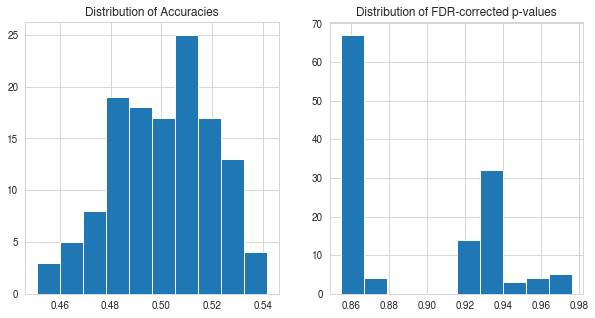

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(statistics_rh[rois,0])
plt.title('Distribution of Accuracies')
plt.subplot(122)
plt.hist(statistics_rh[rois,2])
plt.title('Distribution of FDR-corrected p-values')

## 1.2 Compute left-hand response statistics

In [31]:
rois = np.delete(np.arange(nParcels),smn_rois)
rois = []
rois.extend(np.where(networkdef==networkmappings['fpn'])[0])
rois.extend(np.where(networkdef==networkmappings['dan'])[0])
rois.extend(np.where(networkdef==networkmappings['con'])[0])
# rois.extend(np.where(networkdef==networkmappings['dmn'])[0])
statistics_lh = np.zeros((nParcels,3)) # acc, t, qs
ps = []
for i in rois:
    t, p = stats.ttest_1samp(accuracies_lh[i,:],0.5)
    if t>0:
        p = p/2.0
    else:
        p = 1.0-p/2.0
    ps.append(p)
    
    statistics_lh[i,0] = np.mean(accuracies_lh[i,:])
    statistics_lh[i,1] = t

statistics_lh[:,2] = 1.0
qs = mc.fdrcorrection0(ps)[1]
i = 0
for roi in rois:
    statistics_lh[roi,2] = qs[i]
    i += 1
    
sig_rois = np.where(statistics_lh[:,2]<0.1)[0]
for roi in sig_rois:
    print 'ROI', roi + 1
    print '\tAccuracy:', statistics_lh[roi,0]
    print '\tP-value:', statistics_lh[roi,2]



Text(0.5,1,'Distribution of FDR-corrected p-values')

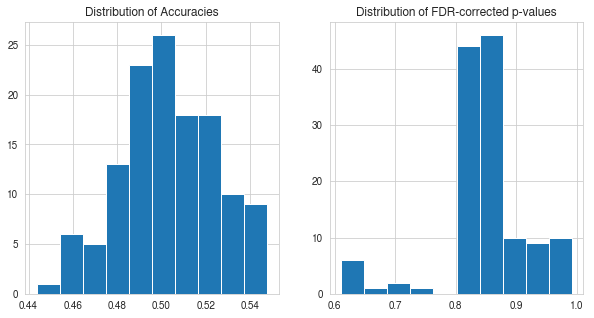

In [32]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(statistics_lh[rois,0])
plt.title('Distribution of Accuracies')
plt.subplot(122)
plt.hist(statistics_lh[rois,2])
plt.title('Distribution of FDR-corrected p-values')